# Utility functions

In [1]:
from datasets.molecules.utils import smiles2graph
from GRALE.data import BatchedDenseData
import torch
from GRALE.vizualization.plots import graph_to_mol, graph_to_smiles
from GRALE.main import GRALE_model
import json
from rdkit import Chem
from huggingface_hub import hf_hub_download


def smiles_to_data(smiles_list, config, device='cuda'):
    '''
    Convert a smiles list to a BatchedDenseData object.
    A BatchedDenseData object contains:
        - h: node mask (batch_size, n_max_nodes)
        - nodes.labels: node labels (batch_size, n_max_nodes, n_node_labels)
        - edges.adjacency: edge adjacency (batch_size, n_max_nodes, n_max_nodes)
        - edges.labels: edge labels (batch_size, n_max_nodes, n_max_nodes, n_edge_labels)
        - edges.SP: shortest path matrix (batch_size, n_max_nodes, n_max_nodes)
    '''
    n_max_nodes = config['n_max_nodes']
    valid_atomic_nums = config['valid_atomic_nums']
    n_node_labels = len(valid_atomic_nums)
    valid_bond_types = config['valid_bond_types']
    n_edge_labels= len(valid_bond_types)
    graphs = [smiles2graph(smiles,n_max_nodes,valid_atomic_nums,valid_bond_types) for smiles in smiles_list]
    h = torch.stack([~torch.tensor(graph['node_mask'],dtype=torch.bool,device=device) for graph in graphs])
    node_labels =  torch.stack([torch.nn.functional.one_hot(torch.tensor(graph['node_labels'], dtype=torch.long, device=device), num_classes=n_node_labels).to(torch.float32) for graph in graphs])
    edge_labels = torch.stack([torch.nn.functional.one_hot(torch.tensor(graph['edge_labels'], dtype=torch.long, device=device), num_classes=n_edge_labels).to(torch.float32) for graph in graphs])
    adjacency = torch.stack([torch.tensor(graph['edge_labels']>0, device=device, dtype=torch.float32) for graph in graphs])
    SP_matrix = torch.stack([torch.tensor(graph['SP_matrix'], device=device, dtype=torch.float32) for graph in graphs])
    data = BatchedDenseData(h=h, nodes={'labels': node_labels}, edges={'adjacency': adjacency, 'labels': edge_labels, 'SP': SP_matrix})
    return data

def data_to_smiles(batched_data, config):
    smiles_list = []
    for data in batched_data:
        h = data.h
        active = h > 0.5
        node_labels = data.nodes.labels[active].cpu().detach().numpy().argmax(-1)
        node_edges = data.edges.labels[active][:,active].cpu().detach().numpy().argmax(-1)
        smiles = graph_to_smiles(node_labels, node_edges)
        smiles_list.append(smiles)
    return smiles_list

def data_to_mol(batched_data, config, sanitize=False):
    mol_list = []
    for data in batched_data:
        h = data.h
        active = h > 0.5
        node_labels = data.nodes.labels[active].cpu().detach().numpy().argmax(-1)
        node_edges = data.edges.labels[active][:,active].cpu().detach().numpy().argmax(-1)
        mol = graph_to_mol(node_labels, node_edges, sanitize=sanitize)
        mol_list.append(mol)
    return mol_list

def load_model(device='cuda'):
    out = hf_hub_download(repo_id="PaulKrzakala/GRALE-128-32", filename="last.ckpt")
    model = GRALE_model.load_from_checkpoint(out).to(device)
    config = json.load(open('datasets/molecules/configs/32.json','r'))
    return model, config

def accuracy(smiles_true, smiles_pred):
    correct = 0
    for s_true, s_pred in zip(smiles_true, smiles_pred):
        s_true_canonical = Chem.CanonSmiles(s_true)
        s_pred_canonical = Chem.CanonSmiles(s_pred)
        if s_true_canonical == s_pred_canonical:
            correct += 1
    return correct / len(smiles_true)


/home/ids/krzakala/anaconda3/envs/GRALEenv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Compute Reconstruction Accuracy

In [6]:
from rdkit.Chem import MolFromSmiles, MolToSmiles

device="cuda"
# Load Model
model, config = load_model(device=device)
# Get SMILES strings
smiles_list = ['CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CC(=O)Oc1ccccc1C(=O)O', 'CC(O)C(=O)O']
# Convert to BatchedDenseData format
data = smiles_to_data(smiles_list, config, device=device)
# Encode and Decode
latent = model.encode(data)
output = model.decode(latent)
# Convert back to SMILES
smiles_out = data_to_smiles(output, config)
# Compute reconstruction accuracy
print(f"Reconstruction accuracy: {accuracy(smiles_list, smiles_out):.2%}")

Reconstruction accuracy: 100.00%


# Plot Reconstruction (2D)

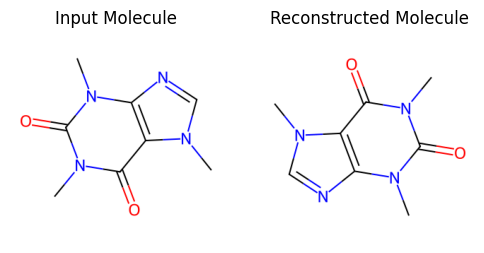

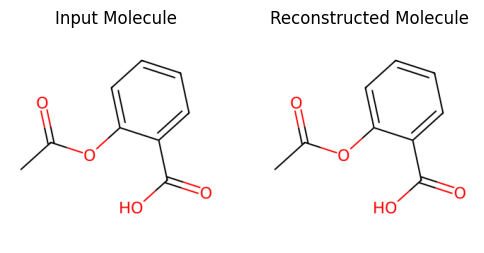

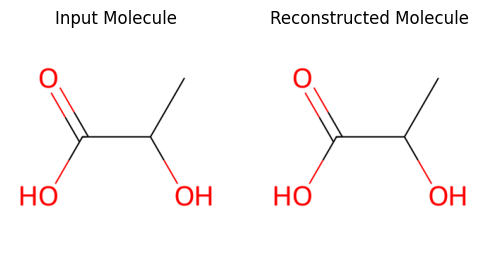

In [7]:
from rdkit.Chem import MolFromSmiles
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

# Load Model
model, config = load_model()
# Get SMILES strings
smiles_list = ['CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CC(=O)Oc1ccccc1C(=O)O', 'CC(O)C(=O)O']
# Convert to BatchedDenseData format
data = smiles_to_data(smiles_list, config)
# Encode and Decode
latent = model.encode(data)
output = model.decode(latent)
smiles_out = data_to_smiles(output, config)

for smi_in, smi_out in zip(smiles_list, smiles_out):
    mol_in = MolFromSmiles(smi_in)
    mol_out = MolFromSmiles(smi_out)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(Draw.MolToImage(mol_in))
    axes[0].set_title('Input Molecule')
    axes[0].axis('off')
    axes[1].imshow(Draw.MolToImage(mol_out))
    axes[1].set_title('Reconstructed Molecule')
    axes[1].axis('off')
    plt.show()

# Plot Reconstruction (3D)

In [8]:
from rdkit.Chem import MolFromSmiles
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

# Load Model
model, config = load_model()
# Get SMILES strings
smiles_list = ['CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CC(=O)Oc1ccccc1C(=O)O', 'CC(O)C(=O)O']
# Convert to BatchedDenseData format
data = smiles_to_data(smiles_list, config)
# Encode and Decode
latent = model.encode(data)
output = model.decode(latent)
mols_out = data_to_mol(output, config, sanitize=True)
mols_in = [MolFromSmiles(smi) for smi in smiles_list]


In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
from IPython.display import HTML

def mol_to_html_view(mol, width=300, height=300):
    # Build 3D structure
    mol3d = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol3d)
    AllChem.UFFOptimizeMolecule(mol3d)
    mol_block = Chem.MolToMolBlock(mol3d)

    # Construct py3Dmol view as HTML
    view = py3Dmol.view(width=width, height=height)
    view.addModel(mol_block, 'mol')
    view.setStyle({'stick': {}, 'sphere': {'scale': 0.3}})
    view.zoomTo()
    return view._make_html()



for mol_in, mol_out in zip(mols_in, mols_out):
    html_in = mol_to_html_view(mol_in)
    html_out = mol_to_html_view(mol_out)

    display(HTML(
        f"""
        <div style="display:flex; gap:20px;">
            <div>{html_in}</div>
            <div>{html_out}</div>
        </div>
        """
    ))
